# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug=False
submission=False
batch_size=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size=128
arch='pretrained'
model_name='se_resnext101_32x4d'
TH = 20

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('seresnext101_1e-4_l1e-4_aug_bs64_onelin')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=image_size, thh = 80, thl = 28, pad=3):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < thl] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

def crop_resize(img0, size=image_size, thh = 80, thl = 28, pad=3):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 5 if (xmin > 5) else 0
    ymin = ymin - 5 if (ymin > 5) else 0
    xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
    ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 42.4 s, sys: 37.9 s, total: 1min 20s
Wall time: 8.52 s


In [10]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [11]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [12]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [13]:
train_dataset_noaug = BengaliAIDataset(train_images, train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [15]:
# print(image[:5,:5])
# print(20/255)

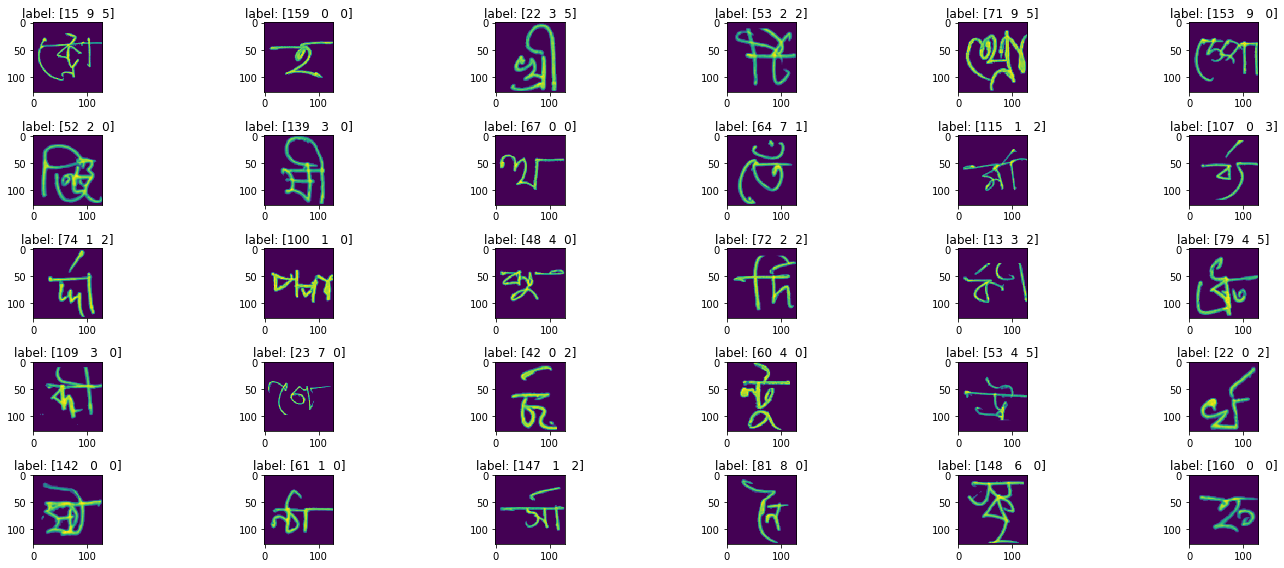

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [17]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{},sx:{}, sy:{}".format(rot_angle,shear_angle, tx,ty, sx, sy))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

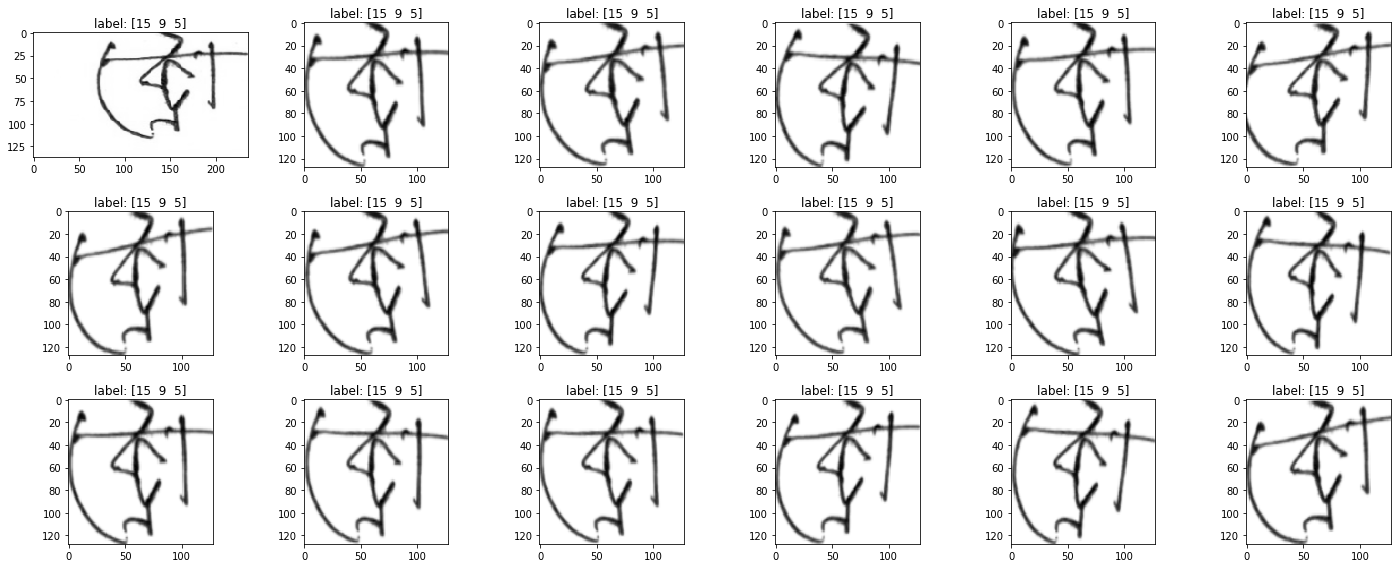

In [18]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[0]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = TH/255, thl=28.0/255, pad=2)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

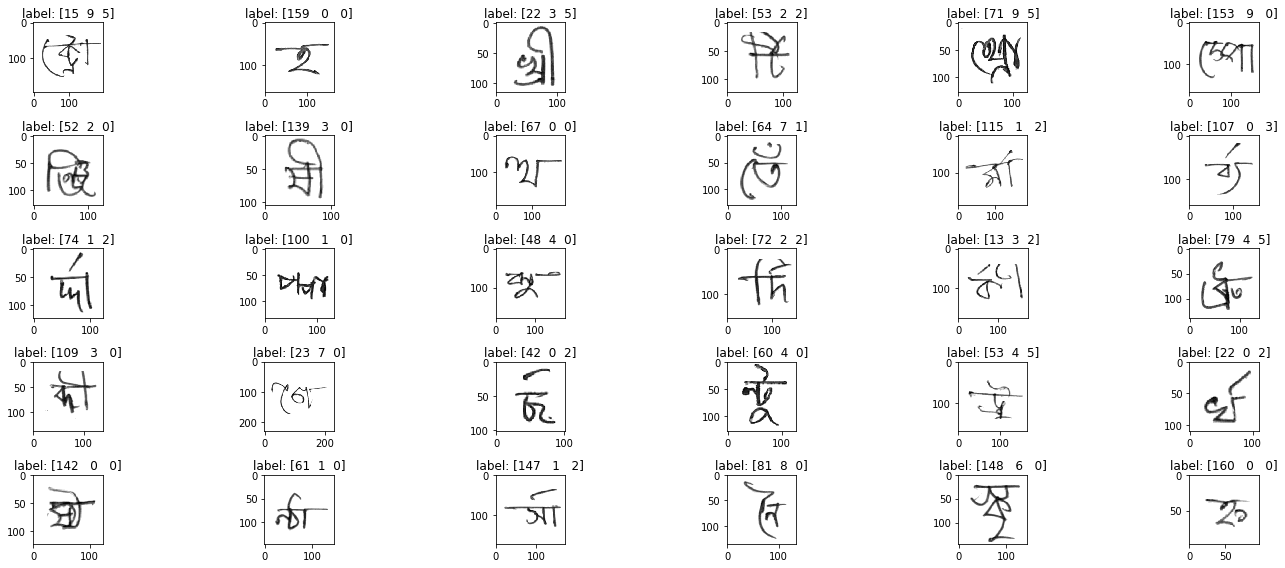

In [19]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

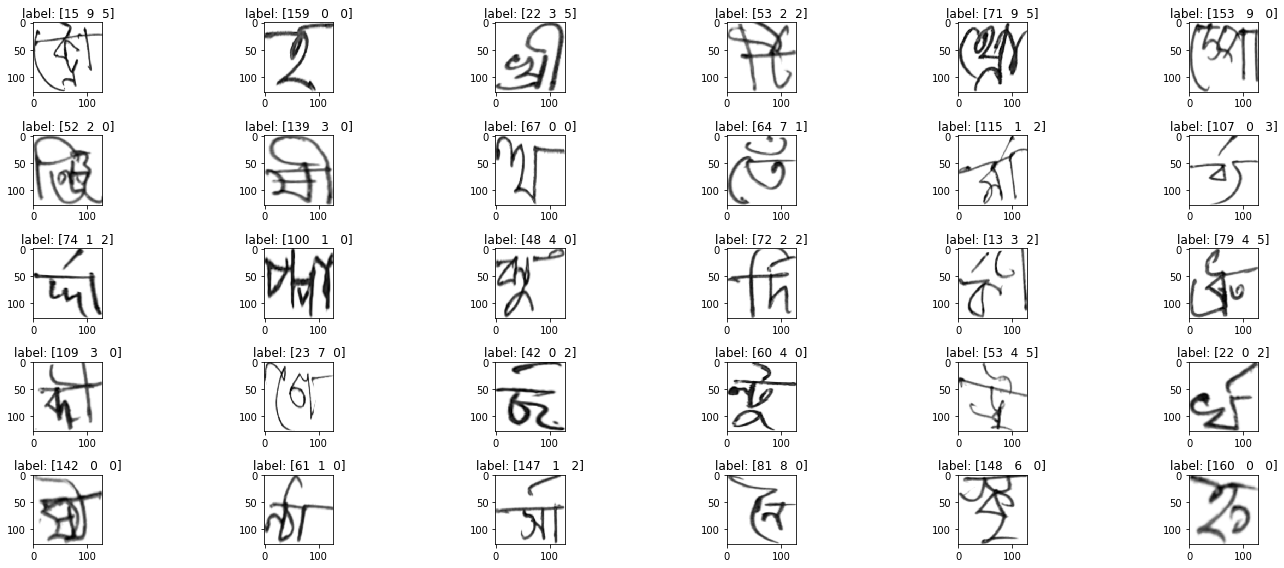

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [21]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=3, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [22]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

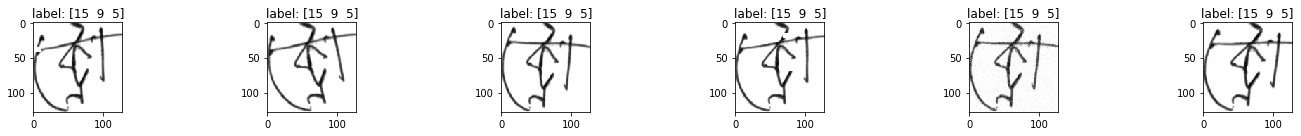

In [23]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

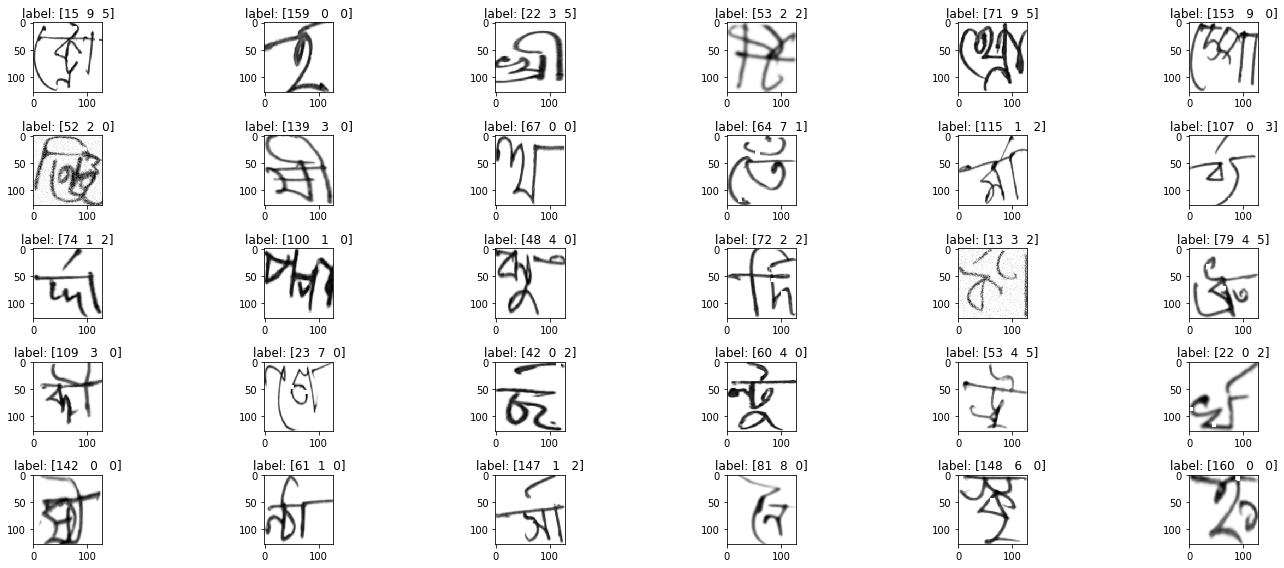

In [24]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [25]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [26]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [27]:
a = np.array([2,3])
b = np.array([4,5,6])

In [28]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [29]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [30]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [31]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False, dropout_ratio = 0.1)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False, dropout_ratio = 0.1)
#         self.lin_layers = Sequential(lin1, lin2)
        self.lin3 = LinearBlock(inch, out_dim, use_bn=use_bn, activation=None, residual=False, dropout_ratio = 0.02) 

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        h = self.lin3(h)
#         for layer in self.lin_layers:
#             h = layer(h)
        return h

## Classifier

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': 2*loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [33]:
import CLR as CLR
import OneCycle as OneCycle

In [34]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [35]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [36]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

# --- Training setting ---

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [37]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [38]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        elem['mode'] = mode
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [39]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [40]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [41]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [42]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [43]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [44]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [45]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(checkpoint['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [46]:
def save_params(outdir, k, img_size, th, arch, model_name):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': model_name}
             )

In [ ]:
import gc

n_epochs = 140
kfold = 2

if not os.path.exists(outdir):
    os.mkdir(outdir)

for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, model_name)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      0 train/loss  7.620450 train/loss_grapheme  5.285689 train/loss_vowel  1.240923 train/loss_consonant  1.093839 train/acc_grapheme  0.592468 train/acc_vowel  0.838839 train/acc_consonant  0.892259 train/recall  0.624884 val/loss  3.540997 val/loss_grapheme  1.972842 val/loss_vowel  0.792985 val/loss_consonant  0.775170 val/acc_grapheme  0.909654 val/acc_vowel  0.977221 val/acc_consonant  0.973412 val/recall  0.901024 lr  0.000100 elapsed_time  2063.712616 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      1 train/loss  4.550615 train/loss_grapheme  3.143615 train/loss_vowel  0.724176 train/loss_consonant  0.682824 train/acc_grapheme  0.844260 train/acc_vowel  0.951821 train/acc_consonant  0.965103 train/recall  0.834932 val/loss  2.184779 val/loss_grapheme  1.204056 val/loss_vowel  0.475046 val/loss_consonant  0.505677 val/acc_grapheme  0.928899 val/acc_vowel  0.980382 val/acc_consonant  0.978839 val/recall  0.923159 lr  0.000100 elapsed_time  4113.936979 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  3.169110 train/loss_grapheme  2.232231 train/loss_vowel  0.483352 train/loss_consonant  0.453526 train/acc_grapheme  0.885537 train/acc_vowel  0.958754 train/acc_consonant  0.972024 train/recall  0.872569 val/loss  1.427206 val/loss_grapheme  0.811929 val/loss_vowel  0.296615 val/loss_consonant  0.318662 val/acc_grapheme  0.943662 val/acc_vowel  0.984191 val/acc_consonant  0.984241 val/recall  0.939092 lr  0.000100 elapsed_time  6159.879866 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  2.297611 train/loss_grapheme  1.649671 train/loss_vowel  0.337046 train/loss_consonant  0.310894 train/acc_grapheme  0.905522 train/acc_vowel  0.962626 train/acc_consonant  0.974980 train/recall  0.892248 val/loss  1.158301 val/loss_grapheme  0.744072 val/loss_vowel  0.206339 val/loss_consonant  0.207890 val/acc_grapheme  0.944209 val/acc_vowel  0.984042 val/acc_consonant  0.983893 val/recall  0.941082 lr  0.000100 elapsed_time  8199.184478 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      4 train/loss  1.752943 train/loss_grapheme  1.287368 train/loss_vowel  0.246201 train/loss_consonant  0.219374 train/acc_grapheme  0.916974 train/acc_vowel  0.966279 train/acc_consonant  0.978154 train/recall  0.905288 val/loss  0.964941 val/loss_grapheme  0.670115 val/loss_vowel  0.144284 val/loss_consonant  0.150542 val/acc_grapheme  0.949139 val/acc_vowel  0.986631 val/acc_consonant  0.984241 val/recall  0.946059 lr  0.000100 elapsed_time  10244.109427 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      5 train/loss  1.400166 train/loss_grapheme  1.045669 train/loss_vowel  0.191651 train/loss_consonant  0.162847 train/acc_grapheme  0.925258 train/acc_vowel  0.968694 train/acc_consonant  0.979903 train/recall  0.913894 val/loss  0.879221 val/loss_grapheme  0.662768 val/loss_vowel  0.107160 val/loss_consonant  0.109293 val/acc_grapheme  0.949014 val/acc_vowel  0.987278 val/acc_consonant  0.985088 val/recall  0.945351 lr  0.000100 elapsed_time  12306.287556 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      6 train/loss  1.188220 train/loss_grapheme  0.903457 train/loss_vowel  0.157225 train/loss_consonant  0.127539 train/acc_grapheme  0.930062 train/acc_vowel  0.970636 train/acc_consonant  0.981428 train/recall  0.918759 val/loss  0.762702 val/loss_grapheme  0.587436 val/loss_vowel  0.088698 val/loss_consonant  0.086569 val/acc_grapheme  0.953122 val/acc_vowel  0.986581 val/acc_consonant  0.986407 val/recall  0.950225 lr  0.000100 elapsed_time  14357.877339 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      7 train/loss  1.028984 train/loss_grapheme  0.788962 train/loss_vowel  0.135067 train/loss_consonant  0.104955 train/acc_grapheme  0.935042 train/acc_vowel  0.972547 train/acc_consonant  0.982909 train/recall  0.925572 val/loss  0.717306 val/loss_grapheme  0.567869 val/loss_vowel  0.077211 val/loss_consonant  0.072226 val/acc_grapheme  0.952923 val/acc_vowel  0.986432 val/acc_consonant  0.986183 val/recall  0.949174 lr  0.000100 elapsed_time  16404.963666 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  0.928318 train/loss_grapheme  0.718881 train/loss_vowel  0.118646 train/loss_consonant  0.090792 train/acc_grapheme  0.937880 train/acc_vowel  0.974351 train/acc_consonant  0.983637 train/recall  0.928823 val/loss  0.701618 val/loss_grapheme  0.568814 val/loss_vowel  0.066084 val/loss_consonant  0.066720 val/acc_grapheme  0.953744 val/acc_vowel  0.987702 val/acc_consonant  0.986233 val/recall  0.950363 lr  0.000100 elapsed_time  18463.948404 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  0.839531 train/loss_grapheme  0.652365 train/loss_vowel  0.106739 train/loss_consonant  0.080428 train/acc_grapheme  0.941141 train/acc_vowel  0.975522 train/acc_consonant  0.984907 train/recall  0.932754 val/loss  0.703364 val/loss_grapheme  0.574427 val/loss_vowel  0.064499 val/loss_consonant  0.064438 val/acc_grapheme  0.952773 val/acc_vowel  0.987204 val/acc_consonant  0.985287 val/recall  0.949944 lr  0.000100 elapsed_time  20523.370026 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  0.794878 train/loss_grapheme  0.620607 train/loss_vowel  0.100973 train/loss_consonant  0.073298 train/acc_grapheme  0.942653 train/acc_vowel  0.976237 train/acc_consonant  0.985411 train/recall  0.934404 val/loss  0.645125 val/loss_grapheme  0.529821 val/loss_vowel  0.058605 val/loss_consonant  0.056699 val/acc_grapheme  0.953321 val/acc_vowel  0.987577 val/acc_consonant  0.986930 val/recall  0.951319 lr  0.000100 elapsed_time  22583.486948 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     11 train/loss  0.750393 train/loss_grapheme  0.586632 train/loss_vowel  0.095358 train/loss_consonant  0.068403 train/acc_grapheme  0.944757 train/acc_vowel  0.977202 train/acc_consonant  0.986202 train/recall  0.937761 val/loss  0.643975 val/loss_grapheme  0.526094 val/loss_vowel  0.060391 val/loss_consonant  0.057489 val/acc_grapheme  0.953670 val/acc_vowel  0.987303 val/acc_consonant  0.986482 val/recall  0.951662 lr  0.000100 elapsed_time  24643.383980 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  0.700701 train/loss_grapheme  0.548950 train/loss_vowel  0.088016 train/loss_consonant  0.063735 train/acc_grapheme  0.947047 train/acc_vowel  0.978671 train/acc_consonant  0.987185 train/recall  0.940067 val/loss  0.632245 val/loss_grapheme  0.522276 val/loss_vowel  0.054349 val/loss_consonant  0.055620 val/acc_grapheme  0.954167 val/acc_vowel  0.988025 val/acc_consonant  0.986258 val/recall  0.951873 lr  0.000100 elapsed_time  26704.959882 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  0.678792 train/loss_grapheme  0.532378 train/loss_vowel  0.085083 train/loss_consonant  0.061331 train/acc_grapheme  0.948765 train/acc_vowel  0.979492 train/acc_consonant  0.987092 train/recall  0.942269 val/loss  0.606132 val/loss_grapheme  0.492860 val/loss_vowel  0.054570 val/loss_consonant  0.058702 val/acc_grapheme  0.954441 val/acc_vowel  0.987951 val/acc_consonant  0.986357 val/recall  0.952073 lr  0.000100 elapsed_time  28763.868905 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  0.647536 train/loss_grapheme  0.508759 train/loss_vowel  0.081807 train/loss_consonant  0.056969 train/acc_grapheme  0.950166 train/acc_vowel  0.980028 train/acc_consonant  0.987863 train/recall  0.942933 val/loss  0.590964 val/loss_grapheme  0.481307 val/loss_vowel  0.055243 val/loss_consonant  0.054415 val/acc_grapheme  0.953943 val/acc_vowel  0.988449 val/acc_consonant  0.987278 val/recall  0.952076 lr  0.000100 elapsed_time  30819.649493 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  0.619114 train/loss_grapheme  0.484716 train/loss_vowel  0.078723 train/loss_consonant  0.055675 train/acc_grapheme  0.951622 train/acc_vowel  0.981098 train/acc_consonant  0.988156 train/recall  0.944986 val/loss  0.570659 val/loss_grapheme  0.468200 val/loss_vowel  0.051562 val/loss_consonant  0.050897 val/acc_grapheme  0.956806 val/acc_vowel  0.988548 val/acc_consonant  0.987652 val/recall  0.954090 lr  0.000100 elapsed_time  32892.097321 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  0.606378 train/loss_grapheme  0.475794 train/loss_vowel  0.076835 train/loss_consonant  0.053748 train/acc_grapheme  0.952275 train/acc_vowel  0.980955 train/acc_consonant  0.988318 train/recall  0.945846 val/loss  0.576843 val/loss_grapheme  0.468075 val/loss_vowel  0.054954 val/loss_consonant  0.053814 val/acc_grapheme  0.957205 val/acc_vowel  0.988449 val/acc_consonant  0.986781 val/recall  0.953521 lr  0.000100 elapsed_time  34945.682115 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  0.583700 train/loss_grapheme  0.458464 train/loss_vowel  0.073105 train/loss_consonant  0.052131 train/acc_grapheme  0.953010 train/acc_vowel  0.982362 train/acc_consonant  0.988697 train/recall  0.947184 val/loss  0.573743 val/loss_grapheme  0.470073 val/loss_vowel  0.052872 val/loss_consonant  0.050798 val/acc_grapheme  0.956134 val/acc_vowel  0.988324 val/acc_consonant  0.987702 val/recall  0.952446 lr  0.000100 elapsed_time  37009.436477 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     18 train/loss  0.569022 train/loss_grapheme  0.447123 train/loss_vowel  0.071652 train/loss_consonant  0.050247 train/acc_grapheme  0.954753 train/acc_vowel  0.982617 train/acc_consonant  0.989258 train/recall  0.948889 val/loss  0.542287 val/loss_grapheme  0.435977 val/loss_vowel  0.056537 val/loss_consonant  0.049774 val/acc_grapheme  0.957528 val/acc_vowel  0.987602 val/acc_consonant  0.987502 val/recall  0.954341 lr  0.000100 elapsed_time  39076.139717 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  0.554783 train/loss_grapheme  0.439767 train/loss_vowel  0.067152 train/loss_consonant  0.047864 train/acc_grapheme  0.955537 train/acc_vowel  0.983569 train/acc_consonant  0.989544 train/recall  0.949559 val/loss  0.583909 val/loss_grapheme  0.476590 val/loss_vowel  0.052807 val/loss_consonant  0.054511 val/acc_grapheme  0.954815 val/acc_vowel  0.988349 val/acc_consonant  0.986606 val/recall  0.950652 lr  0.000100 elapsed_time  41140.999987 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     20 train/loss  0.546038 train/loss_grapheme  0.431511 train/loss_vowel  0.067520 train/loss_consonant  0.047007 train/acc_grapheme  0.955387 train/acc_vowel  0.983550 train/acc_consonant  0.989780 train/recall  0.949761 val/loss  0.591400 val/loss_grapheme  0.484271 val/loss_vowel  0.053938 val/loss_consonant  0.053191 val/acc_grapheme  0.953097 val/acc_vowel  0.988374 val/acc_consonant  0.987154 val/recall  0.950224 lr  0.000100 elapsed_time  43195.738744 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     21 train/loss  0.541264 train/loss_grapheme  0.429157 train/loss_vowel  0.064956 train/loss_consonant  0.047151 train/acc_grapheme  0.955979 train/acc_vowel  0.984210 train/acc_consonant  0.989600 train/recall  0.950106 val/loss  0.599243 val/loss_grapheme  0.495511 val/loss_vowel  0.052964 val/loss_consonant  0.050768 val/acc_grapheme  0.955188 val/acc_vowel  0.988424 val/acc_consonant  0.987353 val/recall  0.952402 lr  0.000100 elapsed_time  45249.220686 mode 000 


100%|██████████| 628/628 [02:52<00:00,  3.63it/s]


epoch     22 train/loss  0.523379 train/loss_grapheme  0.413945 train/loss_vowel  0.065409 train/loss_consonant  0.044025 train/acc_grapheme  0.956763 train/acc_vowel  0.984191 train/acc_consonant  0.990241 train/recall  0.951161 val/loss  0.563729 val/loss_grapheme  0.460760 val/loss_vowel  0.051060 val/loss_consonant  0.051909 val/acc_grapheme  0.954939 val/acc_vowel  0.988249 val/acc_consonant  0.987627 val/recall  0.952533 lr  0.000100 elapsed_time  47318.892881 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     23 train/loss  0.517573 train/loss_grapheme  0.410658 train/loss_vowel  0.062768 train/loss_consonant  0.044146 train/acc_grapheme  0.957416 train/acc_vowel  0.984540 train/acc_consonant  0.989973 train/recall  0.951912 val/loss  0.551316 val/loss_grapheme  0.447407 val/loss_vowel  0.052774 val/loss_consonant  0.051135 val/acc_grapheme  0.955786 val/acc_vowel  0.988449 val/acc_consonant  0.987353 val/recall  0.953167 lr  0.000100 elapsed_time  49386.495572 mode 000 


100%|██████████| 628/628 [02:52<00:00,  3.64it/s]


epoch     24 train/loss  0.499521 train/loss_grapheme  0.394961 train/loss_vowel  0.060914 train/loss_consonant  0.043646 train/acc_grapheme  0.959059 train/acc_vowel  0.985038 train/acc_consonant  0.990160 train/recall  0.952722 val/loss  0.560715 val/loss_grapheme  0.459211 val/loss_vowel  0.050411 val/loss_consonant  0.051092 val/acc_grapheme  0.956358 val/acc_vowel  0.988996 val/acc_consonant  0.987552 val/recall  0.953982 lr  0.000100 elapsed_time  51441.293909 mode 000 


100%|██████████| 628/628 [02:52<00:00,  3.65it/s]


epoch     25 train/loss  0.487887 train/loss_grapheme  0.386990 train/loss_vowel  0.058317 train/loss_consonant  0.042581 train/acc_grapheme  0.959800 train/acc_vowel  0.986034 train/acc_consonant  0.990266 train/recall  0.954509 val/loss  0.572823 val/loss_grapheme  0.465503 val/loss_vowel  0.055237 val/loss_consonant  0.052082 val/acc_grapheme  0.954416 val/acc_vowel  0.987727 val/acc_consonant  0.987254 val/recall  0.951016 lr  0.000100 elapsed_time  53484.257318 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     26 train/loss  0.484990 train/loss_grapheme  0.386424 train/loss_vowel  0.057441 train/loss_consonant  0.041124 train/acc_grapheme  0.959557 train/acc_vowel  0.986326 train/acc_consonant  0.990708 train/recall  0.954736 val/loss  0.573447 val/loss_grapheme  0.466662 val/loss_vowel  0.053196 val/loss_consonant  0.053588 val/acc_grapheme  0.955014 val/acc_vowel  0.988498 val/acc_consonant  0.987378 val/recall  0.952897 lr  0.000100 elapsed_time  55547.366877 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     27 train/loss  0.479121 train/loss_grapheme  0.381130 train/loss_vowel  0.058148 train/loss_consonant  0.039842 train/acc_grapheme  0.959688 train/acc_vowel  0.985940 train/acc_consonant  0.990838 train/recall  0.954770 val/loss  0.576966 val/loss_grapheme  0.469265 val/loss_vowel  0.052923 val/loss_consonant  0.054778 val/acc_grapheme  0.954889 val/acc_vowel  0.988224 val/acc_consonant  0.986631 val/recall  0.951821 lr  0.000100 elapsed_time  57590.726973 mode 000 


 16%|█▌        | 391/2511 [04:54<26:11,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     29 train/loss  0.465145 train/loss_grapheme  0.372725 train/loss_vowel  0.053965 train/loss_consonant  0.038455 train/acc_grapheme  0.960927 train/acc_vowel  0.987160 train/acc_consonant  0.991150 train/recall  0.956340 val/loss  0.561288 val/loss_grapheme  0.454566 val/loss_vowel  0.052185 val/loss_consonant  0.054537 val/acc_grapheme  0.956408 val/acc_vowel  0.988673 val/acc_consonant  0.986955 val/recall  0.951672 lr  0.000100 elapsed_time  61702.854397 mode 100 


 40%|███▉      | 249/628 [01:08<01:43,  3.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     32 train/loss  0.440667 train/loss_grapheme  0.353341 train/loss_vowel  0.050701 train/loss_consonant  0.036625 train/acc_grapheme  0.962601 train/acc_vowel  0.988044 train/acc_consonant  0.991473 train/recall  0.958155 val/loss  0.570138 val/loss_grapheme  0.457265 val/loss_vowel  0.056314 val/loss_consonant  0.056559 val/acc_grapheme  0.954840 val/acc_vowel  0.988722 val/acc_consonant  0.985859 val/recall  0.952694 lr  0.000100 elapsed_time  67862.090163 mode 000 


 88%|████████▊ | 2202/2511 [27:29<03:55,  1.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:50<00:00,  3.67it/s]


epoch     35 train/loss  0.426066 train/loss_grapheme  0.341317 train/loss_vowel  0.048522 train/loss_consonant  0.036227 train/acc_grapheme  0.963777 train/acc_vowel  0.988679 train/acc_consonant  0.991355 train/recall  0.959895 val/loss  0.586663 val/loss_grapheme  0.472112 val/loss_vowel  0.055336 val/loss_consonant  0.059214 val/acc_grapheme  0.955462 val/acc_vowel  0.989046 val/acc_consonant  0.985810 val/recall  0.951524 lr  0.000100 elapsed_time  74030.055275 mode 000 


 68%|██████▊   | 1705/2511 [21:07<10:03,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     38 train/loss  0.404448 train/loss_grapheme  0.326210 train/loss_vowel  0.045314 train/loss_consonant  0.032924 train/acc_grapheme  0.965140 train/acc_vowel  0.989426 train/acc_consonant  0.992314 train/recall  0.961263 val/loss  0.642546 val/loss_grapheme  0.534758 val/loss_vowel  0.051541 val/loss_consonant  0.056247 val/acc_grapheme  0.948616 val/acc_vowel  0.989494 val/acc_consonant  0.986731 val/recall  0.946438 lr  0.000100 elapsed_time  80157.602298 mode 000 


 43%|████▎     | 1083/2511 [13:26<17:30,  1.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:51<00:00,  3.66it/s]


epoch     41 train/loss  0.403145 train/loss_grapheme  0.327001 train/loss_vowel  0.043883 train/loss_consonant  0.032260 train/acc_grapheme  0.965657 train/acc_vowel  0.989955 train/acc_consonant  0.992307 train/recall  0.962322 val/loss  0.572642 val/loss_grapheme  0.463611 val/loss_vowel  0.053145 val/loss_consonant  0.055886 val/acc_grapheme  0.955512 val/acc_vowel  0.988897 val/acc_consonant  0.987005 val/recall  0.953343 lr  0.000100 elapsed_time  86279.613658 mode 000 


  8%|▊         | 210/2511 [02:38<28:57,  1.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     43 train/loss  0.392369 train/loss_grapheme  0.318991 train/loss_vowel  0.042504 train/loss_consonant  0.030874 train/acc_grapheme  0.966124 train/acc_vowel  0.990042 train/acc_consonant  0.992681 train/recall  0.962383 val/loss  0.547976 val/loss_grapheme  0.434967 val/loss_vowel  0.056673 val/loss_consonant  0.056336 val/acc_grapheme  0.958201 val/acc_vowel  0.988050 val/acc_consonant  0.986656 val/recall  0.954652 lr  0.000100 elapsed_time  90350.445375 mode 000 


 92%|█████████▏| 2300/2511 [28:47<02:39,  1.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:51<00:00,  3.67it/s]


epoch     46 train/loss  0.384871 train/loss_grapheme  0.313099 train/loss_vowel  0.041521 train/loss_consonant  0.030251 train/acc_grapheme  0.966173 train/acc_vowel  0.989986 train/acc_consonant  0.992712 train/recall  0.962369 val/loss  0.599581 val/loss_grapheme  0.487467 val/loss_vowel  0.056533 val/loss_consonant  0.055582 val/acc_grapheme  0.955138 val/acc_vowel  0.987826 val/acc_consonant  0.987104 val/recall  0.952862 lr  0.000100 elapsed_time  96529.786221 mode 000 


 65%|██████▍   | 1622/2511 [20:13<11:04,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     49 train/loss  0.379913 train/loss_grapheme  0.307939 train/loss_vowel  0.041624 train/loss_consonant  0.030350 train/acc_grapheme  0.966895 train/acc_vowel  0.990117 train/acc_consonant  0.992855 train/recall  0.963550 val/loss  0.571513 val/loss_grapheme  0.460507 val/loss_vowel  0.054709 val/loss_consonant  0.056297 val/acc_grapheme  0.956856 val/acc_vowel  0.988573 val/acc_consonant  0.987453 val/recall  0.953568 lr  0.000100 elapsed_time  102683.623365 mode 100 


 43%|████▎     | 1077/2511 [13:26<18:05,  1.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     52 train/loss  0.369379 train/loss_grapheme  0.300970 train/loss_vowel  0.039396 train/loss_consonant  0.029014 train/acc_grapheme  0.967891 train/acc_vowel  0.990670 train/acc_consonant  0.993260 train/recall  0.964753 val/loss  0.559803 val/loss_grapheme  0.448444 val/loss_vowel  0.056348 val/loss_consonant  0.055011 val/acc_grapheme  0.958649 val/acc_vowel  0.987801 val/acc_consonant  0.987677 val/recall  0.953972 lr  0.000100 elapsed_time  108809.253306 mode 000 


 11%|█▏        | 284/2511 [03:30<27:23,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     54 train/loss  0.373344 train/loss_grapheme  0.306964 train/loss_vowel  0.038113 train/loss_consonant  0.028267 train/acc_grapheme  0.967250 train/acc_vowel  0.990901 train/acc_consonant  0.993172 train/recall  0.964057 val/loss  0.563520 val/loss_grapheme  0.451132 val/loss_vowel  0.055201 val/loss_consonant  0.057187 val/acc_grapheme  0.959669 val/acc_vowel  0.989021 val/acc_consonant  0.987005 val/recall  0.956450 lr  0.000100 elapsed_time  112855.886694 mode 000 


 91%|█████████▏| 2296/2511 [28:31<02:38,  1.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:50<00:00,  3.68it/s]


epoch     57 train/loss  0.360208 train/loss_grapheme  0.295636 train/loss_vowel  0.037671 train/loss_consonant  0.026901 train/acc_grapheme  0.968271 train/acc_vowel  0.990621 train/acc_consonant  0.993365 train/recall  0.964626 val/loss  0.565208 val/loss_grapheme  0.455944 val/loss_vowel  0.054136 val/loss_consonant  0.055129 val/acc_grapheme  0.957055 val/acc_vowel  0.988598 val/acc_consonant  0.987776 val/recall  0.954051 lr  0.000100 elapsed_time  118979.502601 mode 000 


 39%|███▉      | 986/2511 [12:15<19:04,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:50<00:00,  3.69it/s]


epoch     60 train/loss  0.359541 train/loss_grapheme  0.297240 train/loss_vowel  0.035403 train/loss_consonant  0.026897 train/acc_grapheme  0.968059 train/acc_vowel  0.991504 train/acc_consonant  0.993751 train/recall  0.965057 val/loss  0.581641 val/loss_grapheme  0.461310 val/loss_vowel  0.056647 val/loss_consonant  0.063685 val/acc_grapheme  0.956433 val/acc_vowel  0.988299 val/acc_consonant  0.985685 val/recall  0.952440 lr  0.000100 elapsed_time  125106.761445 mode 000 


 12%|█▏        | 296/2511 [03:40<27:44,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 92%|█████████▏| 579/628 [02:38<00:13,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     65 train/loss  0.355344 train/loss_grapheme  0.292809 train/loss_vowel  0.034754 train/loss_consonant  0.027781 train/acc_grapheme  0.968364 train/acc_vowel  0.991660 train/acc_consonant  0.993141 train/recall  0.965438 val/loss  0.586802 val/loss_grapheme  0.471076 val/loss_vowel  0.056620 val/loss_consonant  0.059106 val/acc_grapheme  0.957030 val/acc_vowel  0.988498 val/acc_consonant  0.986357 val/recall  0.953067 lr  0.000100 elapsed_time  135276.015746 mode 000 


 99%|█████████▉| 2490/2511 [31:01<00:15,  1.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     68 train/loss  0.349906 train/loss_grapheme  0.290022 train/loss_vowel  0.034302 train/loss_consonant  0.025583 train/acc_grapheme  0.967947 train/acc_vowel  0.991735 train/acc_consonant  0.993963 train/recall  0.965896 val/loss  0.592958 val/loss_grapheme  0.480263 val/loss_vowel  0.053937 val/loss_consonant  0.058759 val/acc_grapheme  0.957777 val/acc_vowel  0.988349 val/acc_consonant  0.987901 val/recall  0.954549 lr  0.000100 elapsed_time  141409.684932 mode 000 


 90%|████████▉ | 2248/2511 [27:59<03:18,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     71 train/loss  0.336520 train/loss_grapheme  0.278110 train/loss_vowel  0.034086 train/loss_consonant  0.024324 train/acc_grapheme  0.969540 train/acc_vowel  0.991915 train/acc_consonant  0.994156 train/recall  0.966978 val/loss  0.572101 val/loss_grapheme  0.460783 val/loss_vowel  0.057344 val/loss_consonant  0.053974 val/acc_grapheme  0.958201 val/acc_vowel  0.988424 val/acc_consonant  0.987851 val/recall  0.955375 lr  0.000100 elapsed_time  147532.768651 mode 000 


 70%|███████   | 1769/2511 [21:55<09:17,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 53%|█████▎    | 1332/2511 [16:41<14:36,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     74 train/loss  0.336406 train/loss_grapheme  0.278586 train/loss_vowel  0.032937 train/loss_consonant  0.024883 train/acc_grapheme  0.969690 train/acc_vowel  0.991809 train/acc_consonant  0.994087 train/recall  0.966917 val/loss  0.571491 val/loss_grapheme  0.457254 val/loss_vowel  0.055571 val/loss_consonant  0.058666 val/acc_grapheme  0.958549 val/acc_vowel  0.988623 val/acc_consonant  0.986681 val/recall  0.954772 lr  0.000100 elapsed_time  153681.568327 mode 000 


 57%|█████▋    | 1422/2511 [17:36<13:39,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 1049/2511 [12:59<18:12,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     77 train/loss  0.340181 train/loss_grapheme  0.280749 train/loss_vowel  0.034371 train/loss_consonant  0.025061 train/acc_grapheme  0.969179 train/acc_vowel  0.991324 train/acc_consonant  0.994000 train/recall  0.966712 val/loss  0.573189 val/loss_grapheme  0.456955 val/loss_vowel  0.058445 val/loss_consonant  0.057789 val/acc_grapheme  0.958848 val/acc_vowel  0.987901 val/acc_consonant  0.987328 val/recall  0.954882 lr  0.000100 elapsed_time  159781.261949 mode 000 


 43%|████▎     | 1085/2511 [13:27<17:42,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     79 train/loss  0.335162 train/loss_grapheme  0.277787 train/loss_vowel  0.032522 train/loss_consonant  0.024853 train/acc_grapheme  0.969715 train/acc_vowel  0.992170 train/acc_consonant  0.993982 train/recall  0.967249 val/loss  0.572112 val/loss_grapheme  0.458844 val/loss_vowel  0.057343 val/loss_consonant  0.055925 val/acc_grapheme  0.959794 val/acc_vowel  0.988324 val/acc_consonant  0.987901 val/recall  0.955568 lr  0.000100 elapsed_time  163869.200224 mode 100 


 12%|█▏        | 293/2511 [03:37<27:24,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     80 train/loss  0.331311 train/loss_grapheme  0.272627 train/loss_vowel  0.033934 train/loss_consonant  0.024750 train/acc_grapheme  0.970082 train/acc_vowel  0.991803 train/acc_consonant  0.994118 train/recall  0.967815 val/loss  0.571968 val/loss_grapheme  0.456495 val/loss_vowel  0.056827 val/loss_consonant  0.058645 val/acc_grapheme  0.958425 val/acc_vowel  0.988498 val/acc_consonant  0.987353 val/recall  0.954789 lr  0.000100 elapsed_time  165904.350661 mode 000 


 19%|█▉        | 480/2511 [05:58<25:30,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 127/628 [00:34<02:19,  3.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 164/628 [00:44<02:05,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_

epoch     85 train/loss  0.329368 train/loss_grapheme  0.272904 train/loss_vowel  0.033099 train/loss_consonant  0.023365 train/acc_grapheme  0.969945 train/acc_vowel  0.991897 train/acc_consonant  0.994517 train/recall  0.967840 val/loss  0.577233 val/loss_grapheme  0.459686 val/loss_vowel  0.057872 val/loss_consonant  0.059675 val/acc_grapheme  0.958923 val/acc_vowel  0.988249 val/acc_consonant  0.986681 val/recall  0.954938 lr  0.000100 elapsed_time  176101.166073 mode 000 


 82%|████████▏ | 2068/2511 [25:29<05:28,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 46%|████▌     | 1159/2511 [14:15<16:23,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 628/628 [02:50<00:00,  3.69it/s]


epoch     88 train/loss  0.318453 train/loss_grapheme  0.262451 train/loss_vowel  0.031745 train/loss_consonant  0.024257 train/acc_grapheme  0.971320 train/acc_vowel  0.992133 train/acc_consonant  0.994062 train/recall  0.968032 val/loss  0.600456 val/loss_grapheme  0.484463 val/loss_vowel  0.057688 val/loss_consonant  0.058305 val/acc_grapheme  0.955960 val/acc_vowel  0.988050 val/acc_consonant  0.988025 val/recall  0.953155 lr  0.000100 elapsed_time  182160.868956 mode 000 


 47%|████▋     | 1175/2511 [14:24<16:09,  1.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     90 train/loss  0.312743 train/loss_grapheme  0.256699 train/loss_vowel  0.032259 train/loss_consonant  0.023785 train/acc_grapheme  0.971507 train/acc_vowel  0.992102 train/acc_consonant  0.994243 train/recall  0.968463 val/loss  0.597048 val/loss_grapheme  0.479576 val/loss_vowel  0.057175 val/loss_consonant  0.060297 val/acc_grapheme  0.958325 val/acc_vowel  0.989046 val/acc_consonant  0.987029 val/recall  0.955489 lr  0.000100 elapsed_time  186210.487206 mode 000 


 19%|█▉        | 472/2511 [05:50<25:15,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     91 train/loss  0.315085 train/loss_grapheme  0.261650 train/loss_vowel  0.030494 train/loss_consonant  0.022942 train/acc_grapheme  0.971171 train/acc_vowel  0.992444 train/acc_consonant  0.994318 train/recall  0.968762 val/loss  0.589693 val/loss_grapheme  0.469751 val/loss_vowel  0.058143 val/loss_consonant  0.061799 val/acc_grapheme  0.957155 val/acc_vowel  0.988299 val/acc_consonant  0.986880 val/recall  0.953684 lr  0.000100 elapsed_time  188239.958415 mode 000 


 24%|██▎       | 591/2511 [07:18<23:19,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████▋   | 1686/2511 [20:53<10:10,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     93 train/loss  0.318010 train/loss_grapheme  0.263999 train/loss_vowel  0.030684 train/loss_consonant  0.023327 train/acc_grapheme  0.970505 train/acc_vowel  0.992419 train/acc_consonant  0.994455 train/recall  0.967926 val/loss  0.582003 val/loss_grapheme  0.469382 val/loss_vowel  0.056597 val/loss_consonant  0.056024 val/acc_grapheme  0.958101 val/acc_vowel  0.988697 val/acc_consonant  0.987652 val/recall  0.954773 lr  0.000100 elapsed_time  192304.149264 mode 000 


 72%|███████▏  | 1800/2511 [22:02<08:37,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 39%|███▉      | 979/2511 [12:07<19:03,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     96 train/loss  0.266843 train/loss_grapheme  0.226403 train/loss_vowel  0.023674 train/loss_consonant  0.016766 train/acc_grapheme  0.975858 train/acc_vowel  0.994392 train/acc_consonant  0.996315 train/recall  0.974024 val/loss  0.569261 val/loss_grapheme  0.456669 val/loss_vowel  0.054018 val/loss_consonant  0.058574 val/acc_grapheme  0.960615 val/acc_vowel  0.989395 val/acc_consonant  0.987976 val/recall  0.956439 lr  0.000050 elapsed_time  198387.764479 mode 000 


 32%|███▏      | 806/2511 [09:55<20:42,  1.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 285/628 [01:17<01:33,  3.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 34%|███▍      | 214/628 [00:58<01:53,  3.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_

epoch    101 train/loss  0.247042 train/loss_grapheme  0.210179 train/loss_vowel  0.021673 train/loss_consonant  0.015190 train/acc_grapheme  0.977750 train/acc_vowel  0.994984 train/acc_consonant  0.996801 train/recall  0.976066 val/loss  0.575331 val/loss_grapheme  0.464241 val/loss_vowel  0.052901 val/loss_consonant  0.058189 val/acc_grapheme  0.961238 val/acc_vowel  0.990266 val/acc_consonant  0.988150 val/recall  0.959346 lr  0.000050 elapsed_time  208534.673875 mode 001 


 61%|██████▏   | 1540/2511 [19:01<11:59,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    103 train/loss  0.253596 train/loss_grapheme  0.215757 train/loss_vowel  0.021905 train/loss_consonant  0.015935 train/acc_grapheme  0.977127 train/acc_vowel  0.994859 train/acc_consonant  0.996832 train/recall  0.975374 val/loss  0.568529 val/loss_grapheme  0.457656 val/loss_vowel  0.052347 val/loss_consonant  0.058526 val/acc_grapheme  0.961213 val/acc_vowel  0.989693 val/acc_consonant  0.988249 val/recall  0.958113 lr  0.000050 elapsed_time  212609.258800 mode 000 


 20%|██        | 510/2511 [06:18<24:50,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    104 train/loss  0.254667 train/loss_grapheme  0.217221 train/loss_vowel  0.021830 train/loss_consonant  0.015616 train/acc_grapheme  0.976866 train/acc_vowel  0.995064 train/acc_consonant  0.996720 train/recall  0.975547 val/loss  0.600842 val/loss_grapheme  0.487082 val/loss_vowel  0.056747 val/loss_consonant  0.057013 val/acc_grapheme  0.959321 val/acc_vowel  0.989419 val/acc_consonant  0.987976 val/recall  0.955548 lr  0.000050 elapsed_time  214631.812064 mode 000 


 16%|█▋        | 409/2511 [05:03<26:02,  1.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    106 train/loss  0.237871 train/loss_grapheme  0.206216 train/loss_vowel  0.018769 train/loss_consonant  0.012886 train/acc_grapheme  0.978515 train/acc_vowel  0.995656 train/acc_consonant  0.997560 train/recall  0.977384 val/loss  0.567356 val/loss_grapheme  0.457249 val/loss_vowel  0.053557 val/loss_consonant  0.056550 val/acc_grapheme  0.963080 val/acc_vowel  0.990266 val/acc_consonant  0.988922 val/recall  0.959713 lr  0.000025 elapsed_time  218719.676464 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    107 train/loss  0.230311 train/loss_grapheme  0.199011 train/loss_vowel  0.018678 train/loss_consonant  0.012622 train/acc_grapheme  0.979038 train/acc_vowel  0.995699 train/acc_consonant  0.997566 train/recall  0.977824 val/loss  0.567697 val/loss_grapheme  0.457169 val/loss_vowel  0.054086 val/loss_consonant  0.056442 val/acc_grapheme  0.963453 val/acc_vowel  0.989668 val/acc_consonant  0.988573 val/recall  0.959689 lr  0.000025 elapsed_time  220772.120150 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    108 train/loss  0.235536 train/loss_grapheme  0.203347 train/loss_vowel  0.019611 train/loss_consonant  0.012578 train/acc_grapheme  0.978677 train/acc_vowel  0.995413 train/acc_consonant  0.997604 train/recall  0.977286 val/loss  0.579408 val/loss_grapheme  0.468111 val/loss_vowel  0.054652 val/loss_consonant  0.056644 val/acc_grapheme  0.963379 val/acc_vowel  0.989718 val/acc_consonant  0.989046 val/recall  0.960020 lr  0.000025 elapsed_time  222817.723252 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    109 train/loss  0.227440 train/loss_grapheme  0.195495 train/loss_vowel  0.019117 train/loss_consonant  0.012828 train/acc_grapheme  0.979785 train/acc_vowel  0.995724 train/acc_consonant  0.997374 train/recall  0.978111 val/loss  0.598700 val/loss_grapheme  0.488868 val/loss_vowel  0.054457 val/loss_consonant  0.055374 val/acc_grapheme  0.961985 val/acc_vowel  0.990266 val/acc_consonant  0.989320 val/recall  0.958669 lr  0.000025 elapsed_time  224876.351409 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    110 train/loss  0.233614 train/loss_grapheme  0.203141 train/loss_vowel  0.018649 train/loss_consonant  0.011823 train/acc_grapheme  0.979032 train/acc_vowel  0.995762 train/acc_consonant  0.997803 train/recall  0.977486 val/loss  0.585006 val/loss_grapheme  0.475366 val/loss_vowel  0.053834 val/loss_consonant  0.055806 val/acc_grapheme  0.963404 val/acc_vowel  0.990341 val/acc_consonant  0.988523 val/recall  0.960040 lr  0.000025 elapsed_time  226933.094035 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    111 train/loss  0.230046 train/loss_grapheme  0.199061 train/loss_vowel  0.018704 train/loss_consonant  0.012281 train/acc_grapheme  0.979380 train/acc_vowel  0.995650 train/acc_consonant  0.997660 train/recall  0.977852 val/loss  0.594585 val/loss_grapheme  0.482918 val/loss_vowel  0.054172 val/loss_consonant  0.057495 val/acc_grapheme  0.961686 val/acc_vowel  0.989917 val/acc_consonant  0.988498 val/recall  0.957855 lr  0.000025 elapsed_time  228975.903333 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    112 train/loss  0.228730 train/loss_grapheme  0.199011 train/loss_vowel  0.017804 train/loss_consonant  0.011914 train/acc_grapheme  0.979163 train/acc_vowel  0.995923 train/acc_consonant  0.997722 train/recall  0.977652 val/loss  0.576686 val/loss_grapheme  0.466756 val/loss_vowel  0.054679 val/loss_consonant  0.055251 val/acc_grapheme  0.963653 val/acc_vowel  0.989743 val/acc_consonant  0.988847 val/recall  0.960054 lr  0.000025 elapsed_time  231031.620688 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    113 train/loss  0.226151 train/loss_grapheme  0.196173 train/loss_vowel  0.018068 train/loss_consonant  0.011910 train/acc_grapheme  0.979436 train/acc_vowel  0.995979 train/acc_consonant  0.997666 train/recall  0.978252 val/loss  0.571695 val/loss_grapheme  0.464730 val/loss_vowel  0.052444 val/loss_consonant  0.054521 val/acc_grapheme  0.963379 val/acc_vowel  0.990191 val/acc_consonant  0.989195 val/recall  0.960096 lr  0.000025 elapsed_time  233090.292994 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    114 train/loss  0.228888 train/loss_grapheme  0.198390 train/loss_vowel  0.018059 train/loss_consonant  0.012439 train/acc_grapheme  0.979430 train/acc_vowel  0.995743 train/acc_consonant  0.997560 train/recall  0.978016 val/loss  0.596642 val/loss_grapheme  0.486399 val/loss_vowel  0.051793 val/loss_consonant  0.058450 val/acc_grapheme  0.962931 val/acc_vowel  0.990291 val/acc_consonant  0.988399 val/recall  0.959458 lr  0.000025 elapsed_time  235138.280408 mode 000 


100%|██████████| 628/628 [02:52<00:00,  3.65it/s]


epoch    115 train/loss  0.224190 train/loss_grapheme  0.193908 train/loss_vowel  0.018195 train/loss_consonant  0.012087 train/acc_grapheme  0.979984 train/acc_vowel  0.995948 train/acc_consonant  0.997660 train/recall  0.978381 val/loss  0.615854 val/loss_grapheme  0.504292 val/loss_vowel  0.054226 val/loss_consonant  0.057336 val/acc_grapheme  0.960292 val/acc_vowel  0.989619 val/acc_consonant  0.989046 val/recall  0.957038 lr  0.000025 elapsed_time  237182.308372 mode 000 


100%|██████████| 628/628 [02:51<00:00,  3.65it/s]


epoch    116 train/loss  0.219898 train/loss_grapheme  0.190885 train/loss_vowel  0.017938 train/loss_consonant  0.011074 train/acc_grapheme  0.979953 train/acc_vowel  0.995886 train/acc_consonant  0.997990 train/recall  0.978660 val/loss  0.588132 val/loss_grapheme  0.476723 val/loss_vowel  0.054032 val/loss_consonant  0.057377 val/acc_grapheme  0.963379 val/acc_vowel  0.990042 val/acc_consonant  0.988722 val/recall  0.960115 lr  0.000025 elapsed_time  239238.470028 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    117 train/loss  0.225924 train/loss_grapheme  0.195731 train/loss_vowel  0.018035 train/loss_consonant  0.012158 train/acc_grapheme  0.979872 train/acc_vowel  0.995768 train/acc_consonant  0.997504 train/recall  0.978312 val/loss  0.589494 val/loss_grapheme  0.477677 val/loss_vowel  0.054138 val/loss_consonant  0.057679 val/acc_grapheme  0.963628 val/acc_vowel  0.990241 val/acc_consonant  0.988996 val/recall  0.960220 lr  0.000025 elapsed_time  241289.844365 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    118 train/loss  0.227451 train/loss_grapheme  0.198445 train/loss_vowel  0.017121 train/loss_consonant  0.011885 train/acc_grapheme  0.979343 train/acc_vowel  0.996123 train/acc_consonant  0.997703 train/recall  0.977996 val/loss  0.595480 val/loss_grapheme  0.481545 val/loss_vowel  0.056384 val/loss_consonant  0.057551 val/acc_grapheme  0.963304 val/acc_vowel  0.989768 val/acc_consonant  0.988847 val/recall  0.959697 lr  0.000025 elapsed_time  243336.987942 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    119 train/loss  0.220595 train/loss_grapheme  0.191755 train/loss_vowel  0.017573 train/loss_consonant  0.011267 train/acc_grapheme  0.979847 train/acc_vowel  0.996067 train/acc_consonant  0.997784 train/recall  0.978753 val/loss  0.597766 val/loss_grapheme  0.487170 val/loss_vowel  0.054537 val/loss_consonant  0.056059 val/acc_grapheme  0.963080 val/acc_vowel  0.990166 val/acc_consonant  0.988922 val/recall  0.959970 lr  0.000025 elapsed_time  245394.116982 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    120 train/loss  0.220469 train/loss_grapheme  0.192814 train/loss_vowel  0.016637 train/loss_consonant  0.011017 train/acc_grapheme  0.979772 train/acc_vowel  0.996154 train/acc_consonant  0.997927 train/recall  0.978399 val/loss  0.613787 val/loss_grapheme  0.500104 val/loss_vowel  0.056657 val/loss_consonant  0.057026 val/acc_grapheme  0.963030 val/acc_vowel  0.989370 val/acc_consonant  0.988573 val/recall  0.959625 lr  0.000025 elapsed_time  247445.487201 mode 000 


100%|██████████| 628/628 [02:51<00:00,  3.66it/s]


epoch    121 train/loss  0.209282 train/loss_grapheme  0.182146 train/loss_vowel  0.016454 train/loss_consonant  0.010682 train/acc_grapheme  0.980955 train/acc_vowel  0.996484 train/acc_consonant  0.998145 train/recall  0.979538 val/loss  0.579799 val/loss_grapheme  0.468076 val/loss_vowel  0.055160 val/loss_consonant  0.056563 val/acc_grapheme  0.964698 val/acc_vowel  0.990714 val/acc_consonant  0.988946 val/recall  0.961716 lr  0.000013 elapsed_time  249491.062066 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    122 train/loss  0.214110 train/loss_grapheme  0.187193 train/loss_vowel  0.016030 train/loss_consonant  0.010887 train/acc_grapheme  0.980930 train/acc_vowel  0.996179 train/acc_consonant  0.998077 train/recall  0.979563 val/loss  0.584274 val/loss_grapheme  0.473242 val/loss_vowel  0.053946 val/loss_consonant  0.057086 val/acc_grapheme  0.964325 val/acc_vowel  0.989843 val/acc_consonant  0.989170 val/recall  0.960528 lr  0.000013 elapsed_time  251533.363635 mode 000 


100%|██████████| 628/628 [02:50<00:00,  3.69it/s]


epoch    123 train/loss  0.216315 train/loss_grapheme  0.189053 train/loss_vowel  0.016611 train/loss_consonant  0.010651 train/acc_grapheme  0.980451 train/acc_vowel  0.996160 train/acc_consonant  0.998052 train/recall  0.979081 val/loss  0.608500 val/loss_grapheme  0.498226 val/loss_vowel  0.053746 val/loss_consonant  0.056527 val/acc_grapheme  0.961213 val/acc_vowel  0.990117 val/acc_consonant  0.988872 val/recall  0.957807 lr  0.000013 elapsed_time  253568.194046 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    124 train/loss  0.213231 train/loss_grapheme  0.186586 train/loss_vowel  0.016146 train/loss_consonant  0.010499 train/acc_grapheme  0.980544 train/acc_vowel  0.996415 train/acc_consonant  0.998189 train/recall  0.979361 val/loss  0.594237 val/loss_grapheme  0.482935 val/loss_vowel  0.055302 val/loss_consonant  0.056000 val/acc_grapheme  0.963752 val/acc_vowel  0.990590 val/acc_consonant  0.989619 val/recall  0.961017 lr  0.000013 elapsed_time  255573.938411 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    125 train/loss  0.212384 train/loss_grapheme  0.185382 train/loss_vowel  0.016293 train/loss_consonant  0.010709 train/acc_grapheme  0.980843 train/acc_vowel  0.996104 train/acc_consonant  0.997990 train/recall  0.979276 val/loss  0.579500 val/loss_grapheme  0.469024 val/loss_vowel  0.055502 val/loss_consonant  0.054974 val/acc_grapheme  0.964823 val/acc_vowel  0.990465 val/acc_consonant  0.989320 val/recall  0.961281 lr  0.000013 elapsed_time  257589.429715 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    126 train/loss  0.210437 train/loss_grapheme  0.184384 train/loss_vowel  0.015687 train/loss_consonant  0.010366 train/acc_grapheme  0.981129 train/acc_vowel  0.996639 train/acc_consonant  0.998183 train/recall  0.979982 val/loss  0.587233 val/loss_grapheme  0.477300 val/loss_vowel  0.054364 val/loss_consonant  0.055569 val/acc_grapheme  0.964848 val/acc_vowel  0.990117 val/acc_consonant  0.989668 val/recall  0.961560 lr  0.000006 elapsed_time  259619.692060 mode 000 


  2%|▏         | 39/2511 [00:29<30:24,  1.35it/s] 

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
model_file_name = outdir / 'predictor_{}_{}.pt'.format(0,epoch)
torch.save(predictor.state_dict(), model_file_name)